# EPA1361 - Model-Based Decision Making
# Week 3 - Sensitivity analysis

This exercise uses the same predator-prey model we used for the multi-model exercise, focusing on the Python version. As with the other exercise, define a model object for the function below, with the uncertainty ranges provided:

|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |

* Sensitivity analysis often focuses on the final values of an outcome at the end of the simulation. However, we can also look at metrics that give us additional information about the behavior of the model over time. Using [the statsmodel library](https://www.statsmodels.org/stable/index.html) and an appropriate sampling design, fit a linear regression model for each of the following indicators. What can we conclude about the behavior of the model, and about the importance of the different inputs?

  * The final values of the _prey_ outcome
  * The mean values of the _prey_ outcome over time, within each experiment
  * The standard deviations of the _prey_ outcome over time, within each experiment
  

* Use the Sobol sampling functionality included in the Workbench to perform experiments with a sample size of N=50, then analyze the results with SALib for the same three indicators. This requires specifying the keyword argument `'uncertainty_sampling'` of perform_experiments. Note that when using Sobol sampling, the meaning of the keyword argument `scenarios` changes a bit. In order to properly estimate Sobol scores as well as interaction effects, you require N * (2D+2) scenarios, where D is the number of uncertain parameters, and N is the value for scenarios passed to `perform_experiments`. Repeat the analysis for larger sample sizes, with N=250 and N=1000. How can we interpret the first-order and total indices? Are these sample sizes sufficient for a stable estimation of the indices? You'll need to use the [get_SALib_problem](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/em_framework/salib_samplers.html) function to convert your Workbench experiments to a problem definition that you can pass to the SALib analysis function. 

* *hint*: sobol is a deterministic sequence of quasi random numbers. Thus, you can run with N=1000 and simply slice for 1:50 and 1:250.

* Use the [Extra-Trees analysis](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/analysis/feature_scoring.html) included in the Workbench to approximate the Sobol total indices, with a suitable sampling design. As a starting point, use an ensemble of 100 trees and a max_features parameter of 0.6, and set the analysis to regression mode. Are the estimated importances stable relative to the sample size and the analysis parameters? How do the results compare to the Sobol indices? For more details on this analysis see [Jaxa-Rozen & Kwakkel (2018)](https://www.sciencedirect.com/science/article/pii/S1364815217311581)



In [1]:
### Start of assignment

import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome, perform_experiments, ema_logging, MultiprocessingEvaluator)

from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS

from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol
import pandas as pd
import seaborn as sns



### Python Model Creation

In [2]:
import sys  
sys.path.insert(0, './model/')
import PredPrey as PP

uncertainties = [RealParameter('prey_birth_rate', 0.015, 0.035),
                 RealParameter('predation_rate', 0.0005, 0.003),
                 RealParameter('predator_efficiency', 0.001, 0.004),
                 RealParameter('predator_loss_rate', 0.04, 0.08)] 

outcomes = [TimeSeriesOutcome('TIME', function=np.squeeze),
            TimeSeriesOutcome('predators', function=np.squeeze),
            TimeSeriesOutcome('prey', function=np.squeeze)]

#Define the Python model
py_model = Model('Python', function=PP.PredPrey)
py_model.uncertainties = uncertainties
py_model.outcomes = outcomes

processes = 10


In [3]:
%%html
<link rel="stylesheet" href="style/style.css">

# Linear regression on Prey
The sampling technique chosen for this part is Latin Hypercube Sampling as recommended in the course materials. This method of sampling makes sure that there are no points of the analysis that are not "investigated". 

In [5]:
with MultiprocessingEvaluator(py_model, n_processes=processes) as evaluator:
    experiments, outcomes = perform_experiments(py_model, 50, uncertainty_sampling=LHS)

## Look at final values of prey
The final values of prey are shown in the figure below. 



In [7]:
prey = pd.DataFrame(outcomes["prey"]).T
preyfinal = pd.DataFrame(prey.iloc[-1])

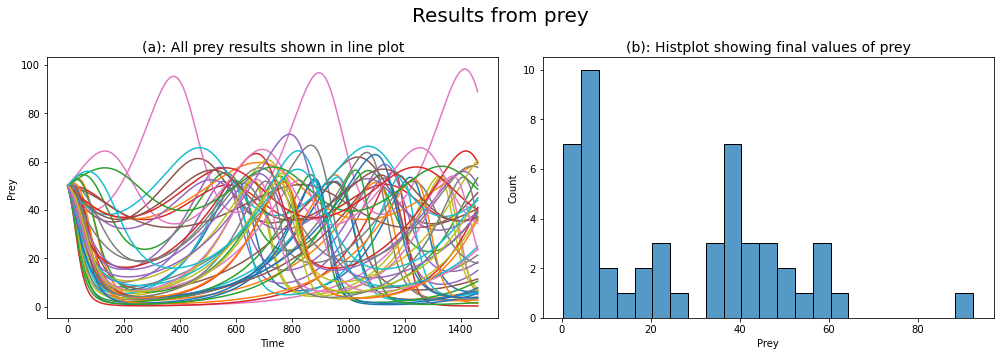

In [8]:
fig, ax = plt.subplots(figsize=(20,15), ncols=2)
prey.plot(legend=None, figsize=(14,5), ax = ax[0])
sns.histplot(data=preyfinal, ax=ax[1], legend=None, binwidth=4)
fig.suptitle('Results from prey', fontsize=20)
ax[0].set_title('(a): All prey results shown in line plot', fontsize=14)
ax[1].set_title('(b): Histplot showing final values of prey', fontsize=14)
ax[1].set_xlabel('Prey')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Prey')
fig.tight_layout()
plt.show()

<h1 class="analysis">Analysis</h1>
<div class="analysis"> 
 Figure (a) shows an overview of all the different model runs. Visual analysis shows that the number of 'large' outliers is around 9. At least the runs, where the model differst more from the rest of the model behaviour. 
- Figre (b) shows the final values of the prey model. Some gaps can be identified there, which means that certain scores of prey are not in the final values. 
</div>

## *Final results* - regression

In [9]:
X = experiments[["predation_rate", "predator_efficiency", "predator_loss_rate", "prey_birth_rate"]]
X = sm.add_constant(X)
Y = preyfinal

In [10]:
# do the regression
mod_fv = sm.OLS(Y, X).fit()

#results of the regression
mod_fv.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   1460   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     14.76
Date:                Thu, 13 May 2021   Prob (F-statistic):           8.87e-08
Time:                        11:38:04   Log-Likelihood:                -201.95
No. Observations:                  50   AIC:                             413.9
Df Residuals:                      45   BIC:                             423.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  37.3262     15.610      2.391      0.021       5.886      68.766
predation_rate        666.4235   2844.770      0.234      0.816   -5063.238    6396.085
predator_efficiency -1.679e+04   2363.149     -7.106      0.000   -2.16e+04    -1.2e+04
predator_loss_rate    332.3645    179.026      1.857      0.070     -28.213     692.942
prey_birth_rate       435.1136    361.144      1.205      0.235    -292.268    1162.495
==============================================================================
Omnibus:                        4.139   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.126   Jarque-Bera (JB):                3.979
Skew:                           0.673   Prob(JB):                        0.137
Kurtosis:                       2.684   Cond. No.                     1.39e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.39e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

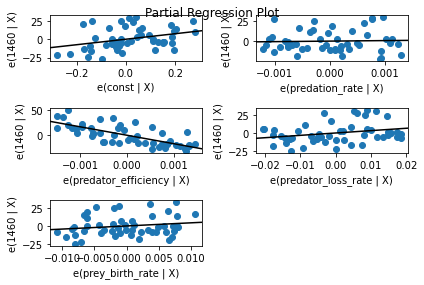

In [11]:
sm.graphics.plot_partregress_grid(mod_fv)
fig.tight_layout(pad=1.0)

<h1 class="analysis">Analysis</h1>
<div class="analysis"> 
    The results mention that the condition number is large. Which might indicate that there is a multicollinearity or other numerical problems.This is seen in the figure above, between e(predation_rate|x) and e(predator_loss_rate|x). <br>
    <br>
The coefficients show that <i>predator loss rate</i> has the most influence on the prey-variable. The P-value indicates that we can reject the null-hypothesis. Note that the margin of error for <i>predation rate</i> and <i>predator efficiency</i> is extremely high.
</div>

## *Mean values* - regression

In [12]:
Y = [i.mean() for i in outcomes["prey"]]
mod_mean = sm.OLS(Y, X).fit()

In [13]:
mod_mean.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     90.22
Date:                Thu, 13 May 2021   Prob (F-statistic):           6.78e-21
Time:                        11:38:13   Log-Likelihood:                -142.98
No. Observations:                  50   AIC:                             296.0
Df Residuals:                      45   BIC:                             305.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  28.4146      4.799      5.921      0.000      18.748      38.081
predation_rate       -877.9919    874.610     -1.004      0.321   -2639.547     883.563
predator_efficiency -1.205e+04    726.538    -16.587      0.000   -1.35e+04   -1.06e+04
predator_loss_rate    416.4823     55.041      7.567      0.000     305.625     527.340
prey_birth_rate       197.8168    111.032      1.782      0.082     -25.813     421.447
==============================================================================
Omnibus:                        9.157   Durbin-Watson:                   2.212
Prob(Omnibus):                  0.010   Jarque-Bera (JB):                8.412
Skew:                           0.891   Prob(JB):                       0.0149
Kurtosis:                       3.928   Cond. No.                     1.39e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.39e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

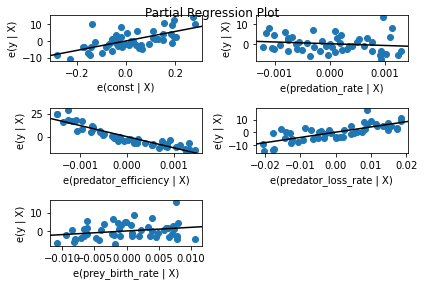

In [14]:
sm.graphics.plot_partregress_grid(mod_mean)
fig.tight_layout(pad=1.0)

<h1 class="analysis">Analysis</h1>
<div class="analysis"> 
    The results mention that the condition number is large. Which might indicate that there is a multicollinearity or other numerical problems.This is seen in the figure above, between e(const|x) and e(predator_loss_rate|x). <br>
    <br>
The coefficients show that <i>predator loss rate</i> has the most influence on the prey-variable. The P-value indicates that we can reject the null-hypothesis. Note that the margin of error for <i>predation rate</i> and <i>predator efficiency</i> is extremely high.
</div>
</div>

## Standard deviations


In [15]:
Y = outcomes["prey"].std(axis=1)
mod_std = sm.OLS(Y, X).fit()

In [16]:
mod_std.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.401
Model:                            OLS   Adj. R-squared:                  0.348
Method:                 Least Squares   F-statistic:                     7.536
Date:                Thu, 13 May 2021   Prob (F-statistic):           9.79e-05
Time:                        11:38:19   Log-Likelihood:                -120.64
No. Observations:                  50   AIC:                             251.3
Df Residuals:                      45   BIC:                             260.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  11.0209      3.070      3.590      0.001       4.838      17.204
predation_rate       1511.1281    559.450      2.701      0.010     384.338    2637.918
predator_efficiency  1950.9905    464.735      4.198      0.000    1014.966    2887.015
predator_loss_rate    -65.6511     35.207     -1.865      0.069    -136.562       5.260
prey_birth_rate       -30.5615     71.022     -0.430      0.669    -173.608     112.485
==============================================================================
Omnibus:                        2.443   Durbin-Watson:                   1.797
Prob(Omnibus):                  0.295   Jarque-Bera (JB):                1.639
Skew:                           0.145   Prob(JB):                        0.441
Kurtosis:                       3.838   Cond. No.                     1.39e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.39e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

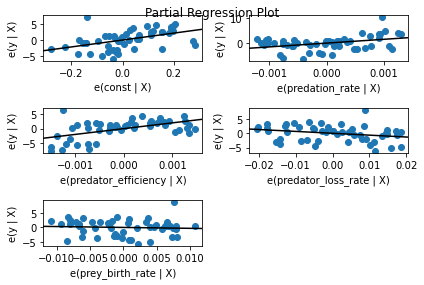

In [17]:
sm.graphics.plot_partregress_grid(mod_std)
fig.tight_layout(pad=1.0)

<h1 class="analysis">Analysis</h1>
<div class="analysis"> 
    The results mention that the condition number is large. Which might indicate that there is a multicollinearity or other numerical problems.This is seen in the figure above, between e(predation_rate|x) and e(predator_efficiency|x). <br>
    <br>
The coefficients show that <i>predator loss rate</i> has the most influence on the prey-variable. The P-value indicates that we can not reject the null-hypothesis. Note that the margin of error for <i>predation rate</i> and <i>predator efficiency</i> is extremely high.
</div>
</div>

### Comparison of the coefficients
The following part is used to analysise the coefficients. 


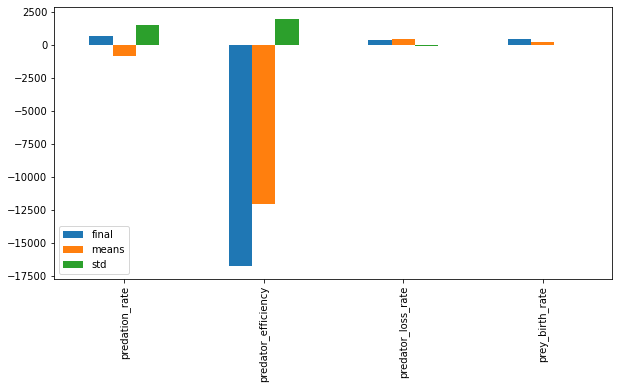

In [18]:
params = pd.DataFrame(mod_fv.params, columns=["final"])
params["means"] = mod_mean.params
params["std"] = mod_std.params
params.drop(index="const", inplace=True)

fig, ax = plt.subplots(figsize=(10,5))
params.plot.bar(ax=ax)
plt.show()

### Comparison of rsquared

In [19]:
print(mod_fv.rsquared_adj)
print(mod_mean.rsquared_adj)
print(mod_std.rsquared_adj)

0.5290948580679158
0.8792716309677742
0.34791934824663817


<h1 class="analysis">Analysis</h1>
<div class="analysis"> 
    As can be seen in the comparison of the coefficients the predator_efficiency has a strong negative effect on the dependent variable (the amount of prey). The predator_loss_rate has the highest positive effect. 
    Predator efficiency has no positive correlation with the amount of prey. Which makes sense, as the predator efficiency increases, the amount of prey decreases.  
    <br>
    <br>
The R-Squared results show that the standard deviation results R-squared score is too low to take into account, the same ccounts for the final-values regression analysis. Only the results from the mean-regression have a high enour R-squared value. As this is the only value above 0.8 or 80%.
</div>
</div>

# Sobol
---
Start of the Sobol analysis

In [ ]:
with MultiprocessingEvaluator(py_model, n_processes=processes) as evaluator:
    sa_experiments, sa_outcomes = perform_experiments(py_model, scenarios=1000 * (2 * 4 + 2), uncertainty_sampling=SOBOL)

problem = get_SALib_problem(py_model.uncertainties)
Si = sobol.analyze(problem, sa_outcomes['prey'].ravel(), calc_second_order=True, print_to_console=False)

scores_filtered = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(scores_filtered, index=problem['names'])

In [ ]:
sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

<h1 class="analysis">Analysis</h1>
<div class="analysis"> 
The figure above shows that for an N value of 50 none of the variables S1 value is higher than the Total effect. However, more important, the inputs where ST index =~ 0 should be discarded. The ST index for the four variables is close to 0 as they are all below 0.005, and examples form the course theory talk abou the 0.1> range. <br><br>
    For an N value of 250 none of the variables S1 value is higher than the Total effect. However, more important, the inputs where ST index =~ 0 should be discarded. The ST index for the four variables is close to 0 as they are all below 0.005, and examples form the course theory talk abou the 0.1> range. <br><br>
    For an N value of 1000 the total indices ... 
</div>
</div>

## Extra-trees analysis
---
Now continue with the extra-trees analysis

In [ ]:
sobol_mean = pd.Series([i.mean() for i in sa_outcomes["prey"]]).astype('int')
sobol_std = pd.Series(sa_outcomes["prey"].std(axis=1)).astype('int')
sobol_final = pd.DataFrame(sa_outcomes["prey"]).T.iloc[-1]

In [ ]:
scores = []
for y in [sobol_mean, sobol_std, sobol_final]:
    scores.append(feature_scoring.get_ex_feature_scores(sa_experiments, y, mode=RuleInductionType.REGRESSION, nr_trees=100, max_features=0.6)[0])

for i in scores:
    sns.heatmap(i, annot=True, cmap='viridis')
    plt.show()

<h1 class="analysis">Analysis</h1>
<div class="analysis"> 
The figure above shows that for none of the variables the S1 value is higher than the Total effect. However, more important, the inputs where ST index =~ 0 should be discarded. The ST index for the four variables is close to 0 as they are all below 0.005, and examples form the course theory talk abou the 0.1> range. 
</div>
</div>

scores_df = pd.concat(scores, axis=1, sort=False)
scores_list = scores_df.to_numpy()

In [ ]:
fig, ax = plt.subplots()
ax.stackplot(range(scores_list.shape[1]), scores_list, labels=scores[0].index.values)
plt.legend()
ax.set_xticks(range(3)) # <--- set the ticks first
ax.set_xticklabels(["Mean", "STD", "Final"])
plt.show()

<h1 class="analysis">Analysis</h1>
<div class="analysis"> 
The figure above shows that for none of the variables the S1 value is higher than the Total effect. However, more important, the inputs where ST index =~ 0 should be discarded. The ST index for the four variables is close to 0 as they are all below 0.005, and examples form the course theory talk abou the 0.1> range. 
</div>
</div>